# MOwNiT
## Laboratorium 2 - Arytmetyka komputerowa


Kalkulatory IEEE-754:
* https://www.h-schmidt.net/FloatConverter/IEEE754.html

In [27]:
# znak, cecha, mantysa
# uwaga - w Julii tablice indeksujemy od 1
# uwaga: ukryta jedynka nie jest pamiętana
# uwaga: cecha jest pamiętana w kodzie z nadmiarem (tutaj BIAS=127)
decode(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))

decode (generic function with 1 method)

In [28]:
using Pkg
Pkg.add("DataFrames")
Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


## Trochę teorii o IEEE-754

Liczby zmienno przecinkowe są zapisywane w standardzie jako:

$L = (-1)^{znak} * mantysa * 2^{cecha}$ 

* znak - 0 oznacza liczbę dodatnią, 1 ujemną
* mantysa - wpływa na precyzje
* cecha - wpływa na zakres, składająca się z samych 0 albo 1 ma specjalne znaczenie

| Nazwa     | Liczba bitów | Bity znaku | Bity cechy | Bity mantysy | Bias  | Dokładność (cyfry znaczące) | Uwagi                                 |
|-----------|--------------|------------|------------|--------------|-------|-----------------------------|---------------------------------------|
| half      | 16           | 1          | 5          | 10           | 15    | 4                           |                                       |
| single    | 32           | 1          | 8          | 23           | 127   | 7                           |                                       |
| double    | 64           | 1          | 11         | 52           | 1023  | 16                          |                                       |
| quadruple | 128          | 1          | 15         | 112          | 16383 | 34                          | Wprowadzone w 2008, niezbyt popularne |

### Liczby znormalizowane

Mantysa ma wartość z przedziału [1,2) - pierwszy bit ma zawsze wartość 1, więc nie trzeba go zapisywać (jest on tam "domyślnie")
$L = (-1)^{znak} * 1.mantysa * 2^{cecha-bias}$

In [29]:
decode(Float32(2.5))

('0', "10000000", "01000000000000000000000")

Policzenie wartości na podstawie reprezentacji bitowej.

In [30]:
cecha = 2^7-127
mantysa = 2^-2 + 1
cecha, mantysa

(1, 1.25)

In [31]:
L = 1 * mantysa * 2^cecha

2.5

### Liczba 0

Wartości 0 nie da się zapisać w postaci znormalizowanej. Jeżeli zarówno mantysa jak i cecha zawierają same 0, to reprezentowana jest wartość 0.

Ze względu na bit znaku, istnieją dwie możliwości 0: +0 oraz -0.

In [32]:
decode(Float32(-0.0))

('1', "00000000", "00000000000000000000000")

In [33]:
decode(Float32(+0.0))

('0', "00000000", "00000000000000000000000")

In [34]:
Float32(-0.0) == Float32(+0.0) # Oba zera są równe

true

### Liczby zdenormalizowane

Jeżeli cecha składa się z samych 0 to liczba jest *zdenormalizowana* i mantysa nie posiada "domyślnego" bitu. Pozwala to na reprezentacje liczb bliskich 0, które bez denormalizacji byłyby 0.

$L = (-1)^{znak} * 0.mantysa * 2^{-bias+1}$

Uwaga: Liczba 0 nie jest określana jako zdenormalizowana, pomimo, że cecha ma same 0!

In [35]:
L = Float32(1e-42)
decode(Float32(L)), issubnormal(L)

(('0', "00000000", "00000000000001011001010"), true)

### Wartości specjalne

####  Nieskończoność

Reprezentowana jest przez cechę z samych 1 oraz mantysę z samych 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

In [36]:
decode(Inf32)

('0', "11111111", "00000000000000000000000")

In [37]:
decode(-Inf32)

('1', "11111111", "00000000000000000000000")

#### NaN

Reprezentowana jest przez cechę z samych 1 oraz mantysę różną od 0.

`NaN`ami są np. 0/0, $\infty - \infty$

In [38]:
Float32(0)/Float32(0)

NaN32

In [39]:
Inf32 - Inf32

NaN32

In [40]:
decode(NaN32)

('0', "11111111", "10000000000000000000000")

### Praktyczne wskazówki

Kolejność działań ma znaczenie:

In [41]:
e = eps(Float32)/2

5.9604645f-8

In [42]:
(Float32(1.0) + e) + e

1.0f0

In [43]:
Float32(1.0) + (e + e)

1.0000001f0

Wniosek: Sumujemy od najmniejszych

Nie powinno się porównywać floatów bezpośrednio. Większość języków posiada funkcje do porówywania liczb zmiennoprzecinkowych z tolerancją, np. `isapprox` w Julii, `numpy.isclose` w Pythonie etc.

In [44]:
0.1 + 0.2 == 0.3

false

In [45]:
isapprox(0.1 + 0.2, 0.3)

true

## Przykłady

In [46]:
bitstring(Float32(.1))

"00111101110011001100110011001101"

In [47]:
bitstring(Float32(1.0))

"00111111100000000000000000000000"

In [48]:
bitstring(Float64(1.0))

"0011111111110000000000000000000000000000000000000000000000000000"

In [49]:
# domyślnie Float64
bitstring(1.0)

"0011111111110000000000000000000000000000000000000000000000000000"

In [50]:
# Float16
bitstring(Float16(1.0))

"0011110000000000"

In [51]:
println(significand(Float32(1.2)), "*2^", exponent(Float32(1.20)))

1.2*2^0


In [52]:
# co ile liczby sa reprezentowane 
c=Float32[]
a=Float32(1.0)
r=1:10
for i=r
    push!(c, a)
    a=nextfloat(a)
end
map(x-> bitstring(x),c)

10-element Vector{String}:
 "00111111100000000000000000000000"
 "00111111100000000000000000000001"
 "00111111100000000000000000000010"
 "00111111100000000000000000000011"
 "00111111100000000000000000000100"
 "00111111100000000000000000000101"
 "00111111100000000000000000000110"
 "00111111100000000000000000000111"
 "00111111100000000000000000001000"
 "00111111100000000000000000001001"

In [53]:
# Maszynowe epsilon mówi, jaki jest odstęp między kolejnymi liczbami zmiennoprzecinkowymi reprezentowanymi w komputerze
eps(Float32(1))

1.1920929f-7

In [54]:
eps(Float32(2))

2.3841858f-7

In [55]:
# Badanie postaci zdenormalizowanej. Co się dzieje, jak liczby są coraz mniejsze?
a = Float32(1e-33)
while a > 0
    a = a/Float32(2.0)
    println(a, decode(a),  " ", issubnormal(a))
end

5.0e-34('0', "00010000", "01001100010011101001100") false
2.5e-34('0', "00001111", "01001100010011101001100") false
1.25e-34('0', "00001110", "01001100010011101001100") false
6.25e-35('0', "00001101", "01001100010011101001100") false
3.125e-35('0', "00001100", "01001100010011101001100") false
1.5625e-35('0', "00001011", "01001100010011101001100") false
7.8125e-36('0', "00001010", "01001100010011101001100") false
3.90625e-36('0', "00001001", "01001100010011101001100") false
1.953125e-36('0', "00001000", "01001100010011101001100") false
9.765625e-37('0', "00000111", "01001100010011101001100") false
4.8828126e-37('0', "00000110", "01001100010011101001100") false
2.4414063e-37('0', "00000101", "01001100010011101001100") false
1.2207032e-37('0', "00000100", "01001100010011101001100") false
6.103516e-38('0', "00000011", "01001100010011101001100") false
3.051758e-38('0', "00000010", "01001100010011101001100") false
1.525879e-38('0', "00000001", "01001100010011101001100") false
7.629395e-39('0

In [56]:
# Rysowanie wykresów
#using Pkg
#Pkg.add("Plots")
# http://docs.juliaplots.org/latest/tutorial/
using Plots

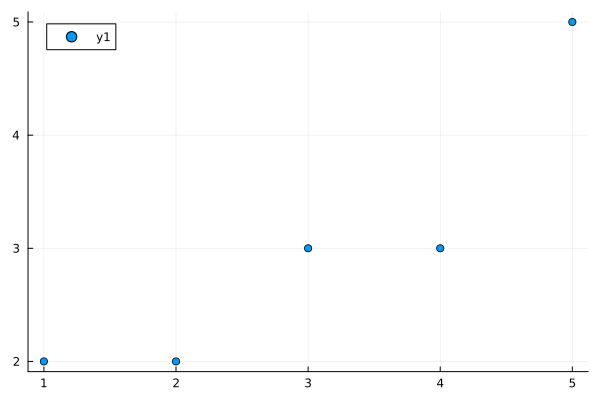

In [57]:
scatter(1:1:5, [2,2,3,3,5])

## Bonus

Ciekawe zastosowanie znajomości IEEE-754 do obliczania odwrotności pierwiastka, wykorzystane w grze Quake 3: [filmik](https://youtu.be/p8u_k2LIZyo)

# Zadania

### Zadanie 1

Porównać w języku Julia reprezentację bitową liczby 1/3 dla `Float16`, `Float32`, `Float64` oraz liczby, 
która jest inicjalizowana jako `Float16`, a potem rzutowana na `Float64`.

In [58]:
using DataFrames, Distributions


df = DataFrame(DecimalValue=Float64, F16=String[], F32=String[], F64=String[], F16toF64=String[])

# bitstring
floats = rand(Uniform(0.0, 20.0), 5)

for f in floats
    f16 = bitstring(Float16(f))
    f32 = bitstring(Float32(f))
    f64 = bitstring(Float64(f))
    f16tof64 = bitstring(Float64(Float16(f)))

    push!(df, (f, f16, f32, f64, f16tof64), promote=true)
end

sort!(df, [:DecimalValue])


5×5 DataFrame
 Row │ DecimalValue  F16               F32                               F64   ⋯
     │ Any           String            String                            Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2.80255       0100000110011011  01000000001100110101110011101001  01000 ⋯
   2 │ 3.00932       0100001000000101  01000000010000001001100010101010  01000
   3 │ 5.24201       0100010100111110  01000000101001111011111010000110  01000
   4 │ 7.33714       0100011101010110  01000000111010101100100111011110  01000
   5 │ 13.6043       0100101011001101  01000001010110011010101101001111  01000 ⋯
                                                               2 columns omitted

### Zadanie 2

Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka Julia. 
Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

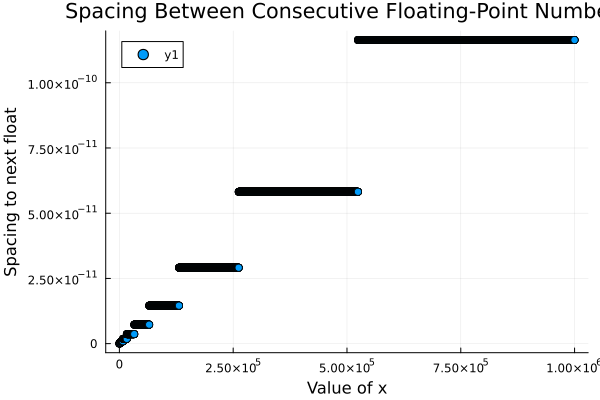

In [113]:
using Plots

x_values = 1.0:100.0:1_000_000.0

differences = [nextfloat(x) - x for x in x_values]

scatter(x_values, differences, xlabel="Value of x", ylabel="Spacing to next float",
        title="Spacing Between Consecutive Floating-Point Numbers")

### Zadanie 3

Jedną z bibliotek numerycznych, jaką dodatkowo będziemy używać na zajęciach jest <a href="http://www.gnu.org/software/gsl/gsl.html">GSL</a> (język C). Opis <a href="https://www.gnu.org/software/gsl/doc/html/usage.html"> jak używać </a>. Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

Kod załączyć jako komórka Markdown sformatowana jako C ([link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#code)). Wynik także jako Markdown (kod albo fragment zrzutu ekranu).

### Implementation using GSL library
```c
#include <stdio.h>
#include <gsl/gsl_ieee_utils.h>

// Please use below line for compiling. It specifies directory with gsl installed
// gcc main.c -I/opt/homebrew/include -L/opt/homebrew/lib -lgsl -Wall -o main

int main (void) {
    float n = 1.0;

    for (; n > 0; n = n / 16.5) {
        gsl_ieee_printf_float(&n);
        printf("\n");
    }

    gsl_ieee_printf_float(&n);
    printf("\n");

    return 0;
}
```

### Test results
```bash
jkaczmarski@JAKACZMA-M-RT4J:mownit/lab2 $ ./main
 1.00000000000000000000000*2^0
 1.11110000011111000010000*2^-5
 1.11100001011100001001110*2^-9
 1.11010010110110011100111*2^-13
 1.11000100101101000010110*2^-17
 1.10110110111111000100101*2^-21
 1.10101001101011101101010*2^-25
 1.10011100110010001001000*2^-29
 1.10010000010001100101111*2^-33
 1.10000100001001010011010*2^-37
 1.01111000011000100010001*2^-41
 1.01101100111110100101000*2^-45
 1.01100001111010101111100*2^-49
 1.01010111001100010110110*2^-53
 1.01001100110010110001010*2^-57
 1.01000010101101010110100*2^-61
 1.00111000111011011111100*2^-65
 1.00101111011100100110010*2^-69
 1.00100110010000000110000*2^-73
 1.00011101010101011011001*2^-77
 1.00010100101100000011000*2^-81
 1.00001100010011011100001*2^-85
 1.00000100001011000110000*2^-89
 1.11111000100101000010000*2^-94
 1.11101001010010011101001*2^-98
 1.11011010011101100010000*2^-102
 1.11001100000101010111010*2^-106
 1.10111110001001000101001*2^-110
 1.10110000100111110101100*2^-114
 1.10100011100000110011111*2^-118
 1.10010110110011001101100*2^-122
 1.10001010011110010001000*2^-126
 0.00010111111010000100111*2^-126 # -> First denormalized number (has leading 0)
 0.00000001011100101110111*2^-126
 0.00000000000101100111110*2^-126
 0.00000000000000010101110*2^-126
 0.00000000000000000001011*2^-126
 0.00000000000000000000001*2^-126
 0
 ```

### Zadanie 4

Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Wszystkie punkty przedstawić w postaci notatnika Julii.

In [114]:
function euler_truly_unstable(x; max_iter=100)
    res = 1.0

    for i in 1:max_iter
        term = x^i / factorial(i)
        res += term
    end

    return res
end

function euler_stable(x; tolerance=1e-10, max_iter=100)
    if x < 0
        return 1 / euler_stable(-x)
    end

    res = 1
    # prev element in sequence
    prev = 1

    for i in 1:max_iter
        # More efectively compute factorial, using prev element of seq
        prev *= x / i
        res += prev

        if abs(prev) < tolerance
            break
        end
    end

    return res
end

test_cases = [-5.5, -15.5, 3]

for x in test_cases
    unstable_res = euler_unstable(x)
    stable_res = euler_stable(x)
    println("****")
    println("Testing value: $(x).")
    println("Euler Unstable for $(x): $(unstable_res)")
    println("Euler Stable for $(x): $(stable_res)")
    println("Difference: $(abs(unstable_res - stable_res))")
end


****
Testing value: -5.5.
Euler Unstable for -5.5: 2.377684454539466
Euler Stable for -5.5: 0.004086771438464287
Difference: 2.3735976831010017
****
Testing value: -15.5.
Euler Unstable for -15.5: 131944.48927711905
Euler Stable for -15.5: 1.855391362615977e-7
Difference: 131944.4892769335
****
Testing value: 3.0.
Euler Unstable for 3.0: 20.079665178571425
Euler Stable for 3.0: 20.085536923183504
Difference: 0.00587174461207951
